In [345]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import math

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import initializers

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import xgboost as xgb
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

#from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [346]:
def quartersToHours(data):
    data['date_forecast'] = pd.to_datetime(data['date_forecast'], format='%Y-%m.%d %H:%M:%S')
    data["year"] = data['date_forecast'].dt.year
    data["month"] = data['date_forecast'].dt.month
    data["day"] = data['date_forecast'].dt.day
    data["hour"] = data['date_forecast'].dt.hour


    group = data.groupby([data["year"], data["month"], data["day"], data["hour"]])  
    result = group.mean()
    result = result.reset_index()
    
    return_df = result.drop(['year','month', 'day', 'hour'], axis=1)
    
    return return_df

In [347]:
def join_data_and_labels(train, val, labels):
    
    #Remove hour and minute values
    val = val.assign(date_forecast=val.date_forecast.dt.round('H'))
    train = train.assign(date_forecast=train.date_forecast.dt.round('H'))
    
    #rename columns names to match
    
    train = train.rename(columns={'date_forecast': 'date'})
    val = val.rename(columns={'date_forecast': 'date'})
    labels = labels.rename(columns={'time': 'date'})
    
    joined_train = pd.merge(train, labels, how="inner", on="date")
    joined_val = pd.merge(val, labels, how="inner", on="date")

    
    return joined_train, joined_val

In [348]:
def join_data(observed, estimated, labels):
    #Remove hour and minute values
    observed = observed.assign(date_forecast=observed.date_forecast.dt.round('H'))
    estimated = estimated.assign(date_forecast=estimated.date_forecast.dt.round('H'))
    
    #rename columns names to match
    observed = observed.rename(columns={'date_forecast': 'date'})
    estimated = estimated.rename(columns={'date_forecast': 'date'})
    labels = labels.rename(columns={'time': 'date'})
    
    data = pd.concat([observed, estimated])
    joined_data = pd.merge(data, labels, how="inner", on="date")
    
    return joined_data
    

In [349]:
def remove_unused_columns(df):
    df = df.drop(['snow_drift:idx', 'elevation:m'], axis=1)
    return df


In [350]:
def drop_constanst_columns(train, val, test):
    constanst_columns = []
    # Remove constants
    for key, value in test.std().items():
        if value == 0.0:
            constanst_columns.append(key)

    train.drop(constanst_columns, axis=1,inplace=True)
    val.drop(constanst_columns, axis=1,inplace=True)
    test.drop(constanst_columns, axis=1,inplace=True)

In [351]:
def convert_date_to_sin_and_cos(df):
    day = 24*60*60 #seconds in a day
    year = (365.2425)*day #seconds in a year
    month = year / 12.0

    date_time = pd.to_datetime(df['date'], format='%Y-%m.%d %H:%M:%S')
    
    timestamp_s = date_time.map(pd.Timestamp.timestamp)

    #df['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
    #df['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
    
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    
    df['Hour sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Hour cos'] = np.cos(timestamp_s * (2 * np.pi / day))
   

In [352]:
def feature_date(df):
    df["month"] = [df["date"][i].month for i in range(len(df))]
    df["hour"] = [df["date"][i].hour for i in range(len(df))]
    df.pop('date')


In [353]:
def round_is_day(df):
    df["is_day:idx"] = [round(df["is_day:idx"][i]) for i in range(len(df))]
    df["is_in_shadow:idx"] = [round(df["is_in_shadow:idx"][i]) for i in range(len(df))]
    

In [354]:
def normalize_except_columns(df):
    not_to_be_norm = ["is_day:idx", 'is_in_shadow:idx', 'Hour sin', 'Hour cos',"Year sin", "Year cos", "month", "Hour", "pv_measurement"]
    cols = df.columns.tolist()
    cols_to_norm = [i for i in cols if i not in not_to_be_norm]
    
    df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))


In [355]:
def combine_features(df, features, new_name):
    
    totals = []
    
    for i in range(len(df)):
        total = 0
        for feature in features:
            total += df[feature][i]
        
        totals.append(total)
            
   
    #df.drop(features, axis=1, inplace=True)
    df[new_name] = totals
    df[new_name] = df[new_name] #/ df[new_name].max()

In [356]:
def split_data(df):
    val_split = 0.2
   
    len_df = len(df)
    train_len = int(len_df * (1.0 - val_split))

    train = df.iloc[:train_len,:]
    val = df.iloc[train_len:,:]
    
    
    train = train.reset_index()
    train = train.drop(['index'], axis=1)
    
    val = val.reset_index()
    val = val.drop(['index'], axis=1)
    
    return train, val

In [357]:
train_a = pd.read_parquet('dataset/A/train_targets.parquet')
train_b = pd.read_parquet('dataset/B/train_targets.parquet')
train_c = pd.read_parquet('dataset/C/train_targets.parquet')

In [358]:
a_max = train_a["pv_measurement"].max()
b_max = train_b["pv_measurement"].max()
c_max = train_c["pv_measurement"].max()

In [359]:
#Load data, sample to hours and drop columns which are not needed
X_train_observed_a = quartersToHours(pd.read_parquet('dataset/A/X_train_observed.parquet')) #Train_x
X_train_observed_b = quartersToHours(pd.read_parquet('dataset/B/X_train_observed.parquet'))
X_train_observed_c = quartersToHours(pd.read_parquet('dataset/C/X_train_observed.parquet'))

X_train_estimated_a = quartersToHours(pd.read_parquet('dataset/A/X_train_estimated.parquet')) # Val_x
X_train_estimated_a = X_train_estimated_a.drop(["date_calc"], axis=1)

X_train_estimated_b = quartersToHours(pd.read_parquet('dataset/B/X_train_estimated.parquet'))
X_train_estimated_b = X_train_estimated_b.drop(["date_calc"], axis=1)

X_train_estimated_c = quartersToHours(pd.read_parquet('dataset/C/X_train_estimated.parquet'))
X_train_estimated_c = X_train_estimated_c.drop(["date_calc"], axis=1)

X_test_estimated_a = quartersToHours(pd.read_parquet('dataset/A/X_test_estimated.parquet'))
X_test_estimated_a = X_test_estimated_a.drop(["date_calc"], axis=1)
test_a = X_test_estimated_a.rename(columns={'date_forecast': 'date'})

X_test_estimated_b = quartersToHours(pd.read_parquet('dataset/B/X_test_estimated.parquet'))
X_test_estimated_b = X_test_estimated_b.drop(["date_calc"], axis=1)
test_b = X_test_estimated_b.rename(columns={'date_forecast': 'date'})

X_test_estimated_c = quartersToHours(pd.read_parquet('dataset/C/X_test_estimated.parquet'))
X_test_estimated_c = X_test_estimated_c.drop(["date_calc"], axis=1)
test_c = X_test_estimated_c.rename(columns={'date_forecast': 'date'})

In [360]:
data_a = join_data(X_train_observed_a, X_train_estimated_a, train_a)
data_b = join_data(X_train_observed_b, X_train_estimated_b, train_b)
data_c = join_data(X_train_observed_c, X_train_estimated_c, train_c)

In [361]:
# Fill 0 for NaNs
data_a = data_a.fillna(0)
test_a = test_a.fillna(0)

data_b = data_b.fillna(0)
test_b = test_b.fillna(0)

data_c = data_c.fillna(0)
test_c = test_c.fillna(0)

In [362]:
class Window:
    def __init__(self, targets, window_size=100):
        self.targets = targets
        self.window_size = window_size
        
        self.start = 0
        self.end = self.window_size
        
        
    def get(self):
        return self.targets[self.start: self.end]
    
    def next(self):
        self.start += 1
        self.end += 1
        
    def hasNext(self):
        if self.end < len(self.targets):
            return True
        
        return False
        
        

def find_constants(df):
    WINDOW_SIZE = 24
    
    window = Window(df["pv_measurement"], WINDOW_SIZE)
    
    constants = []
    
    while window.hasNext():
        if window.get().std() <= 0.1:
            constants.append((window.start, window.end))
        window.next()
            
    def extract_indices(ranges):
        return [start for start, _ in ranges]


    indices = extract_indices(constants)
    
    
    df = df.drop(indices)
    df = df.reset_index()
    df = df.drop(['index'], axis=1)
    
    return df
    
    
    

In [ ]:
data_a = find_constants(data_a)
data_b = find_constants(data_b)
data_c = find_constants(data_c)

In [ ]:
#Convert date into sin and cos components
convert_date_to_sin_and_cos(data_a)
convert_date_to_sin_and_cos(test_a)

convert_date_to_sin_and_cos(data_b)
convert_date_to_sin_and_cos(test_b)

convert_date_to_sin_and_cos(data_c)
convert_date_to_sin_and_cos(test_c)

In [ ]:
# Isday should be a binary value
round_is_day(data_a)
round_is_day(test_a)

round_is_day(data_b)
round_is_day(test_b)

round_is_day(data_c)
round_is_day(test_c)

In [ ]:
#normalize_except_columns(train_data_a)
#normalize_except_columns(val_data_a)
#normalize_except_columns(test_a)

#normalize_except_columns(train_data_b)
#normalize_except_columns(val_data_b)
#normalize_except_columns(test_b)

#normalize_except_columns(train_data_c)
#normalize_except_columns(val_data_c)
#normalize_except_columns(test_c)

In [ ]:
combine_features(data_a, ['direct_rad:W', 'diffuse_rad:W'], 'global_rad:W')
combine_features(test_a, ['direct_rad:W', 'diffuse_rad:W'], 'global_rad:W')

combine_features(data_a, ['direct_rad_1h:J', 'diffuse_rad_1h:J'], 'global_rad_1h:J')
combine_features(test_a, ['direct_rad_1h:J', 'diffuse_rad_1h:J'], 'global_rad_1h:J')


combine_features(data_b, ['direct_rad:W', 'diffuse_rad:W'], 'global_rad:W')
combine_features(test_b, ['direct_rad:W', 'diffuse_rad:W'], 'global_rad:W')

combine_features(data_b, ['direct_rad_1h:J', 'diffuse_rad_1h:J'], 'global_rad_1h:J')
combine_features(test_b, ['direct_rad_1h:J', 'diffuse_rad_1h:J'], 'global_rad_1h:J')


combine_features(data_c, ['direct_rad:W', 'diffuse_rad:W'], 'global_rad:W')
combine_features(test_c, ['direct_rad:W', 'diffuse_rad:W'], 'global_rad:W')

combine_features(data_c, ['direct_rad_1h:J', 'diffuse_rad_1h:J'], 'global_rad_1h:J')
combine_features(test_c, ['direct_rad_1h:J', 'diffuse_rad_1h:J'], 'global_rad_1h:J')

In [ ]:
# Fill 0 for NaNs
data_a = data_a.fillna(0)
test_a = test_a.fillna(0)

data_b = data_b.fillna(0)
test_b = test_b.fillna(0)

data_c = data_c.fillna(0)
test_c = test_c.fillna(0)

In [ ]:
data_a = remove_unused_columns(data_a)
test_a = remove_unused_columns(test_a)

data_b = remove_unused_columns(data_b)
test_b = remove_unused_columns(test_b)

data_c = remove_unused_columns(data_c)
test_c = remove_unused_columns(test_c)

In [ ]:
#data_a["pv_measurement"] = [math.log(data_a["pv_measurement"][i] +1) for i in range(len(data_a))]
#data_b["pv_measurement"] = [math.log(data_b["pv_measurement"][i] +1) for i in range(len(data_b))]
#data_c["pv_measurement"] = [math.log(data_c["pv_measurement"][i] +1) for i in range(len(data_c))]

In [ ]:
corr = data_a.corr()[['pv_measurement']].sort_values(by='pv_measurement', ascending=False)
plt.figure(figsize=(24, 24))

sns.heatmap(corr, annot=True)

In [ ]:
train_data_a, val_data_a = split_data(data_a)
train_data_b, val_data_b = split_data(data_b)
train_data_c, val_data_c = split_data(data_c)

In [ ]:
train_data_c["pv_measurement"].plot()

In [130]:
train_data_a.drop(["date"], axis=1, inplace=True)
val_data_a.drop(["date"], axis=1, inplace=True)
test_a.drop(["date"], axis=1, inplace=True)

train_data_b.drop(["date"], axis=1, inplace=True)
val_data_b.drop(["date"], axis=1, inplace=True)
test_b.drop(["date"], axis=1, inplace=True)


train_data_c.drop(["date"], axis=1, inplace=True)
val_data_c.drop(["date"], axis=1, inplace=True)
test_c.drop(["date"], axis=1, inplace=True)


In [131]:
train_a_y = train_data_a.pop("pv_measurement")
val_a_y = val_data_a.pop("pv_measurement")

train_b_y = train_data_b.pop("pv_measurement")
val_b_y = val_data_b.pop("pv_measurement")

train_c_y = train_data_c.pop("pv_measurement")
val_c_y = val_data_c.pop("pv_measurement")

In [132]:
def modelfit(alg, xs, ys, val_xs, val_ys, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(xs, label=ys)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, 
                          early_stopping_rounds=early_stopping_rounds, verbose_eval =True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(xs, ys, eval_set=[(xs, ys),(val_xs, val_ys)], verbose=True)
        
    #Predict training set:
    dtrain_predictions = alg.predict(xs)
    dval_predictions = alg.predict(val_xs)
    
    mae = mean_absolute_error(dtrain_predictions, ys)
    mae_val = mean_absolute_error(dval_predictions, val_ys)
    print(mae, mae_val)
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [133]:
import gc
gc.collect()

147

[13:59:18] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	validation_0-mae:632.25870	validation_1-mae:480.27245
[1]	validation_0-mae:603.20873	validation_1-mae:459.00708
[2]	validation_0-mae:575.46410	validation_1-mae:438.58351
[3]	validation_0-mae:549.53244	validation_1-mae:419.84570
[4]	validation_0-mae:525.09029	validation_1-mae:401.65641
[5]	validation_0-mae:502.09501	validation_1-mae:384.12695
[6]	validation_0-mae:480.61989	validation_1-mae:368.50086
[7]	validation_0-mae:460.34550	validation_1-mae:353.84691
[8]	validation_0-mae:441.55630	validation_1-mae:340.66073
[9]	validation_0-mae:424.17170	validation_1-mae:328.11512
[10]	validation_0-mae:407.98427	validation_1-mae:316.61775
[11]	validation_0-mae:392.82383	validation_1-mae:306.16529
[12]	validation_0-mae:378.66406	validation_1-mae:296.15915
[13]	validation_0-mae:365.85699	validation_1-mae:287.31328
[14]	validation_0-mae:353.83880	validation_1

[137]	validation_0-mae:141.55078	validation_1-mae:164.72185
[138]	validation_0-mae:141.33762	validation_1-mae:164.58585
[139]	validation_0-mae:141.10363	validation_1-mae:164.49047
[140]	validation_0-mae:140.93164	validation_1-mae:164.47043
[141]	validation_0-mae:140.86079	validation_1-mae:164.48161
[142]	validation_0-mae:140.68525	validation_1-mae:164.48064
[143]	validation_0-mae:140.56059	validation_1-mae:164.52344
[144]	validation_0-mae:140.38994	validation_1-mae:164.41915
[145]	validation_0-mae:140.27948	validation_1-mae:164.37334
[146]	validation_0-mae:140.21203	validation_1-mae:164.41294
[147]	validation_0-mae:140.11363	validation_1-mae:164.40105
[148]	validation_0-mae:139.96039	validation_1-mae:164.29875
[149]	validation_0-mae:139.88859	validation_1-mae:164.31361
[150]	validation_0-mae:139.65755	validation_1-mae:164.25408
[151]	validation_0-mae:139.55476	validation_1-mae:164.22211
[152]	validation_0-mae:139.43869	validation_1-mae:164.27016
[153]	validation_0-mae:139.33506	validat

[274]	validation_0-mae:118.55675	validation_1-mae:162.21149
[275]	validation_0-mae:118.39109	validation_1-mae:162.19826
[276]	validation_0-mae:118.22062	validation_1-mae:162.22524
[277]	validation_0-mae:118.01427	validation_1-mae:162.21243
[278]	validation_0-mae:117.91188	validation_1-mae:162.20481
[279]	validation_0-mae:117.82144	validation_1-mae:162.22530
[280]	validation_0-mae:117.72789	validation_1-mae:162.23765
[281]	validation_0-mae:117.64848	validation_1-mae:162.24746
[282]	validation_0-mae:117.36590	validation_1-mae:162.20400
[283]	validation_0-mae:117.29422	validation_1-mae:162.20689
[284]	validation_0-mae:117.20244	validation_1-mae:162.22541
[285]	validation_0-mae:117.05343	validation_1-mae:162.22608
[286]	validation_0-mae:116.86693	validation_1-mae:162.24741
[287]	validation_0-mae:116.71064	validation_1-mae:162.29337
[288]	validation_0-mae:116.55315	validation_1-mae:162.29866
[289]	validation_0-mae:116.43314	validation_1-mae:162.29998
[290]	validation_0-mae:116.35266	validat

[411]	validation_0-mae:99.04389	validation_1-mae:162.25614
99.0438942052654 162.2561402464227


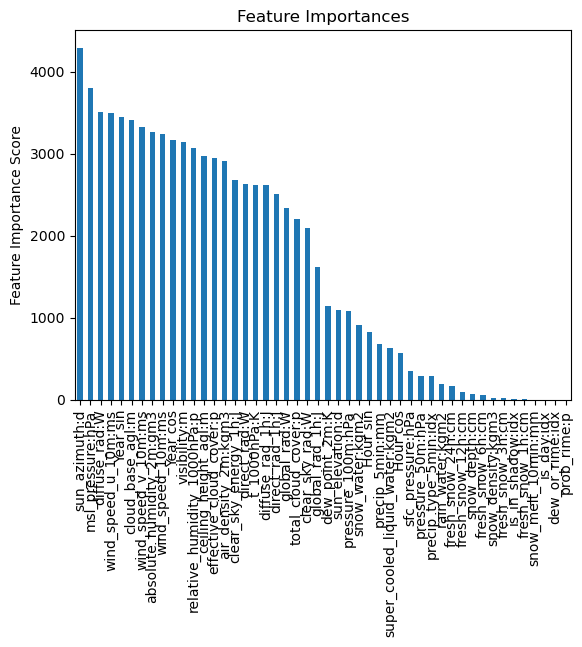

In [134]:
model_a = xgb.XGBRegressor(
 device='cuda',
 learning_rate =0.05,
 n_estimators=412,
 max_depth=9,
 min_child_weight=3,
 gamma=0.04528544718783674,
 subsample=0.9998025705497127,
 colsample_bytree=0.921306456483126,
 nthread=4,
 seed=42,
 eval_metric= 'mae',
 booster='gbtree',
 reg_alpha = 6.269765758117039,
 reg_lambda = 104.97034261208167,
)
#0.19613293622734407 0.40573645313601164 n=142
#0.1928914046341721 0.407310147382544 n=158

#{'colsample_bytree': 0.921306456483126, 'gamma': 0.04528544718783674, 'max_depth': 9.0, 'min_child_weight': 3.0
#, 'reg_alpha': 6.269765758117039, 'reg_lambda': 104.97034261208167, 'subsample': 0.9998025705497127}

#0.15693694340836295 0.39086275948007354 n = 106
#0.16197148623791022 0.38602162197583617 n = 412

modelfit(model_a, train_data_a, train_a_y, val_data_a, val_a_y, useTrainCV = False)

[14:00:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	validation_0-mae:85.69039	validation_1-mae:57.78343
[1]	validation_0-mae:82.17654	validation_1-mae:55.96258
[2]	validation_0-mae:78.84668	validation_1-mae:54.36994
[3]	validation_0-mae:75.64318	validation_1-mae:52.56381
[4]	validation_0-mae:72.69785	validation_1-mae:51.09531
[5]	validation_0-mae:69.87966	validation_1-mae:49.57804
[6]	validation_0-mae:67.21790	validation_1-mae:48.14940
[7]	validation_0-mae:64.89662	validation_1-mae:47.02359
[8]	validation_0-mae:62.65683	validation_1-mae:45.84325
[9]	validation_0-mae:60.53168	validation_1-mae:44.94476
[10]	validation_0-mae:58.57139	validation_1-mae:44.16196
[11]	validation_0-mae:56.76142	validation_1-mae:43.15895
[12]	validation_0-mae:55.03450	validation_1-mae:42.51761
[13]	validation_0-mae:53.43770	validation_1-mae:41.73385
[14]	validation_0-mae:51.92644	validation_1-mae:40.97210
[15]	validation

[141]	validation_0-mae:17.41820	validation_1-mae:33.04137
[142]	validation_0-mae:17.36462	validation_1-mae:33.06286
[143]	validation_0-mae:17.31606	validation_1-mae:33.08357
[144]	validation_0-mae:17.26982	validation_1-mae:33.08959
[145]	validation_0-mae:17.21099	validation_1-mae:33.11709
[146]	validation_0-mae:17.16335	validation_1-mae:33.14282
[147]	validation_0-mae:17.10966	validation_1-mae:33.14436
[148]	validation_0-mae:17.08302	validation_1-mae:33.16546
[149]	validation_0-mae:17.01745	validation_1-mae:33.17450
[150]	validation_0-mae:16.97893	validation_1-mae:33.17613
[151]	validation_0-mae:16.92977	validation_1-mae:33.21529
[152]	validation_0-mae:16.87778	validation_1-mae:33.23280
[153]	validation_0-mae:16.84476	validation_1-mae:33.24890
[154]	validation_0-mae:16.77562	validation_1-mae:33.26500
[155]	validation_0-mae:16.72265	validation_1-mae:33.30170
[156]	validation_0-mae:16.66624	validation_1-mae:33.30266
[157]	validation_0-mae:16.64117	validation_1-mae:33.29525
[158]	validati

[283]	validation_0-mae:11.94998	validation_1-mae:34.44139
[284]	validation_0-mae:11.90535	validation_1-mae:34.44968
[285]	validation_0-mae:11.88271	validation_1-mae:34.44135
[286]	validation_0-mae:11.86083	validation_1-mae:34.44764
[287]	validation_0-mae:11.83702	validation_1-mae:34.44420
[288]	validation_0-mae:11.81268	validation_1-mae:34.44744
[289]	validation_0-mae:11.78001	validation_1-mae:34.45742
[290]	validation_0-mae:11.74993	validation_1-mae:34.47990
[291]	validation_0-mae:11.70098	validation_1-mae:34.47551
[292]	validation_0-mae:11.66737	validation_1-mae:34.47587
[293]	validation_0-mae:11.64402	validation_1-mae:34.48431
[294]	validation_0-mae:11.62208	validation_1-mae:34.48454
[295]	validation_0-mae:11.59494	validation_1-mae:34.48775
[296]	validation_0-mae:11.56421	validation_1-mae:34.48682
[297]	validation_0-mae:11.53179	validation_1-mae:34.49539
[298]	validation_0-mae:11.51240	validation_1-mae:34.49704
[299]	validation_0-mae:11.47807	validation_1-mae:34.51753
[300]	validati

[426]	validation_0-mae:8.69459	validation_1-mae:35.02026
[427]	validation_0-mae:8.67523	validation_1-mae:35.02579
[428]	validation_0-mae:8.65026	validation_1-mae:35.03201
[429]	validation_0-mae:8.62373	validation_1-mae:35.03198
[430]	validation_0-mae:8.59382	validation_1-mae:35.04020
[431]	validation_0-mae:8.57100	validation_1-mae:35.04099
[432]	validation_0-mae:8.56143	validation_1-mae:35.04525
[433]	validation_0-mae:8.53704	validation_1-mae:35.04603
[434]	validation_0-mae:8.52715	validation_1-mae:35.04188
[435]	validation_0-mae:8.51078	validation_1-mae:35.04633
[436]	validation_0-mae:8.48604	validation_1-mae:35.04758
[437]	validation_0-mae:8.46565	validation_1-mae:35.04616
[438]	validation_0-mae:8.44482	validation_1-mae:35.04676
[439]	validation_0-mae:8.42939	validation_1-mae:35.04510
[440]	validation_0-mae:8.40329	validation_1-mae:35.04475
[441]	validation_0-mae:8.38557	validation_1-mae:35.04457
[442]	validation_0-mae:8.36304	validation_1-mae:35.04352
[443]	validation_0-mae:8.33904	

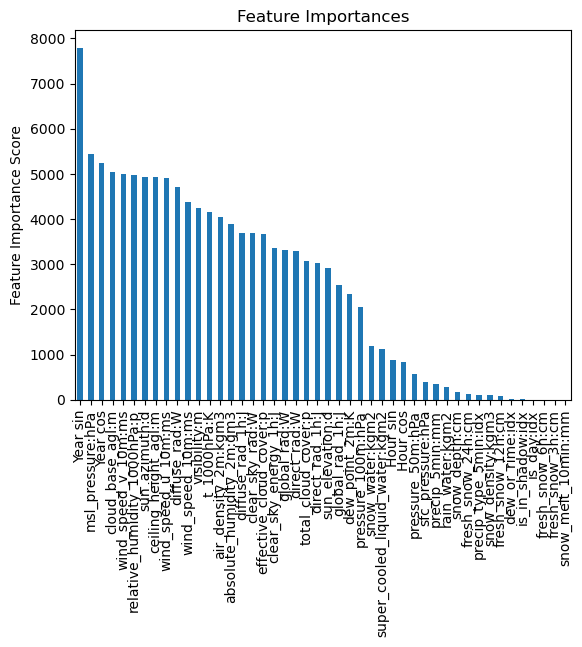

In [135]:
model_b = xgb.XGBRegressor(
 device='cuda',
 learning_rate = 0.05,
 n_estimators=458,
 max_depth=17,
 min_child_weight=9,
 gamma=2.3530939377340916,
 subsample=0.6745835850987192,
 colsample_bytree=0.8563576286836063,
 nthread=4,
 seed=42,
 eval_metric= 'mae',
 booster='gbtree',
 reg_lambda=64.39374187968356,
 reg_alpha=5.362099435153887
)
#0.06212898149188478 0.7860634391376136 n=1446
#0.1222095301072687 0.6839349532956208 n=179
#0.13434825285500354 0.6990262771620205 n=69

#0.12756632201545706 0.6692457267452019 n=258

#{'colsample_bytree': 0.8563576286836063, 'gamma': 2.3530939377340916, 'max_depth': 17.0, 'min_child_weight': 9.0, 
#'reg_alpha': 5.362099435153887, 'reg_lambda': 64.39374187968356, 'subsample': 0.6745835850987192}

#0.310756931729991 0.6349991820881153
#0.31407279322815446 0.6355752480210978 n=458

modelfit(model_b, train_data_b, train_b_y, val_data_b, val_b_y, useTrainCV = False)

[14:01:24] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	validation_0-mae:80.99797	validation_1-mae:45.20880
[1]	validation_0-mae:77.28496	validation_1-mae:43.21323
[2]	validation_0-mae:73.79129	validation_1-mae:41.61900
[3]	validation_0-mae:70.43750	validation_1-mae:40.15799
[4]	validation_0-mae:67.28576	validation_1-mae:38.97205
[5]	validation_0-mae:64.29444	validation_1-mae:37.65575
[6]	validation_0-mae:61.46270	validation_1-mae:36.50904
[7]	validation_0-mae:58.78797	validation_1-mae:35.35741
[8]	validation_0-mae:56.27027	validation_1-mae:34.33583
[9]	validation_0-mae:53.93404	validation_1-mae:33.45498
[10]	validation_0-mae:51.75992	validation_1-mae:32.54787
[11]	validation_0-mae:49.68532	validation_1-mae:31.70205
[12]	validation_0-mae:47.72174	validation_1-mae:30.91009
[13]	validation_0-mae:45.92375	validation_1-mae:30.29305
[14]	validation_0-mae:44.22747	validation_1-mae:29.68237
[15]	validation

[140]	validation_0-mae:17.13902	validation_1-mae:23.06311
[141]	validation_0-mae:17.10623	validation_1-mae:23.07272
[142]	validation_0-mae:17.07149	validation_1-mae:23.06735
[143]	validation_0-mae:17.04983	validation_1-mae:23.06387
[144]	validation_0-mae:17.02245	validation_1-mae:23.06671
[145]	validation_0-mae:17.01515	validation_1-mae:23.07001
[146]	validation_0-mae:17.00618	validation_1-mae:23.06500
[147]	validation_0-mae:16.98469	validation_1-mae:23.06813
[148]	validation_0-mae:16.94386	validation_1-mae:23.06640
[149]	validation_0-mae:16.91060	validation_1-mae:23.05894
[150]	validation_0-mae:16.88706	validation_1-mae:23.05797
[151]	validation_0-mae:16.85473	validation_1-mae:23.05546
[152]	validation_0-mae:16.83608	validation_1-mae:23.05585
[153]	validation_0-mae:16.82492	validation_1-mae:23.04184
[154]	validation_0-mae:16.81177	validation_1-mae:23.04391
[155]	validation_0-mae:16.80709	validation_1-mae:23.04391
[156]	validation_0-mae:16.78888	validation_1-mae:23.05714
[157]	validati

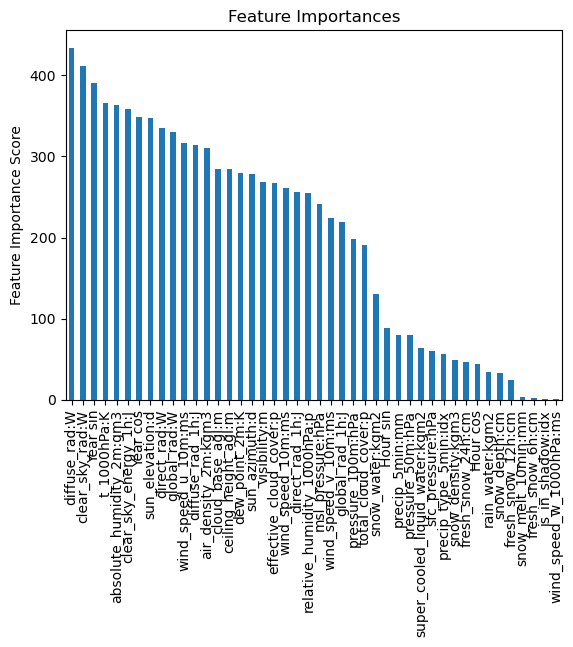

In [136]:
model_c = xgb.XGBRegressor(
 device='cuda',
 learning_rate =0.05,
 n_estimators=177,
 max_depth=6,
 min_child_weight=2,
 gamma=8.04170092116208,
 subsample=0.9062851430836057,
 colsample_bytree=0.5738783499201188,
 nthread=4,
 seed=42,
 eval_metric= 'mae',
 booster='gbtree',
 reg_lambda=28.47495736969533,
 reg_alpha=9.717435079225815,
)
#0.1744061185589522 0.5526189701373168 n=185
#0.1183515260953625 0.41969272541442876 n=54
#0.1498275281202949 0.4007762283140363 n=275

#0.15131079440533324 0.3813320560700485 n=1002

#{'colsample_bytree': 0.5738783499201188, 'gamma': 8.04170092116208, 'max_depth': 6.0, 'min_child_weight': 2.0, 
#'reg_alpha': 9.717435079225815, 'reg_lambda': 28.47495736969533, 'subsample': 0.9062851430836057}
#0.28462223894132316 0.36287898840442134

#0.2872643709884008 0.3690443543272938 n=177
modelfit(model_c, train_data_c, train_c_y, val_data_c, val_c_y, useTrainCV = False)

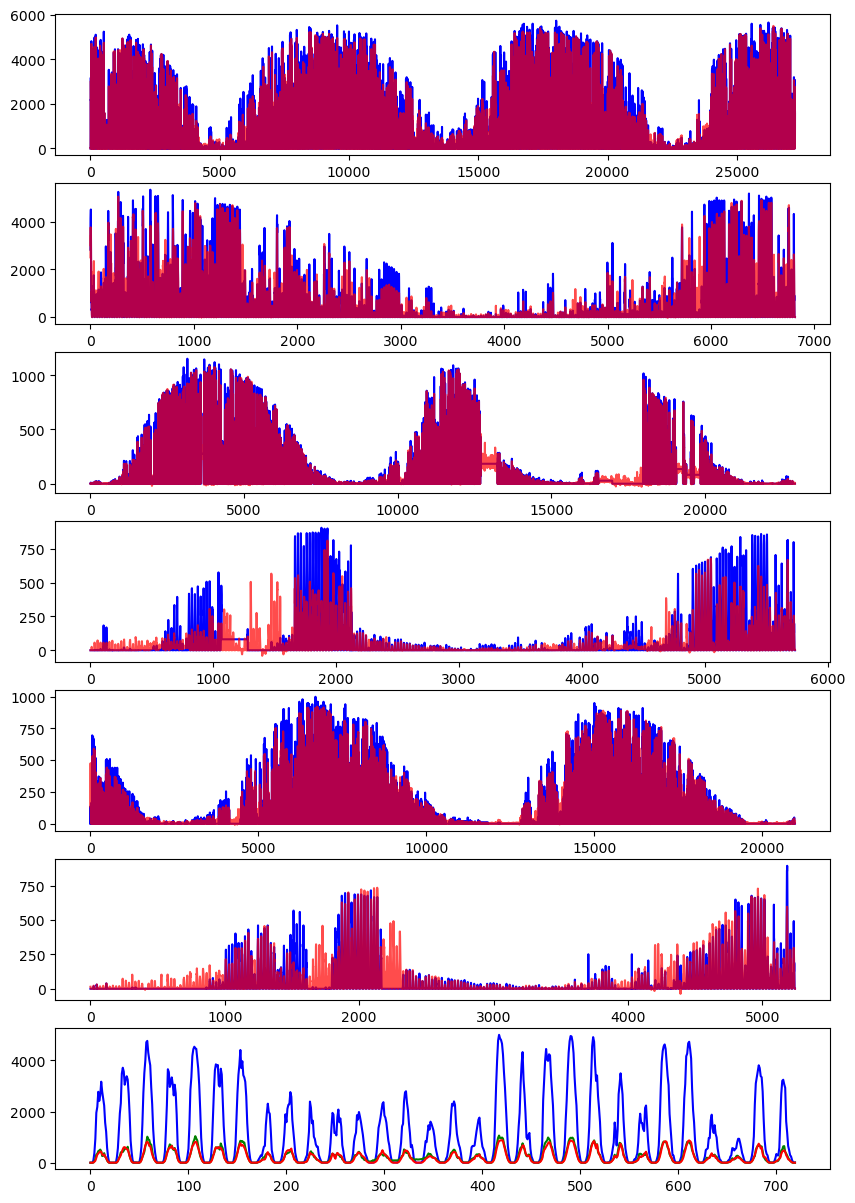

In [137]:
preds_a_train = model_a.predict(train_data_a)
preds_a_val = model_a.predict(val_data_a)
preds_a_test = model_a.predict(test_a)

preds_b_train = model_b.predict(train_data_b)
preds_b_val = model_b.predict(val_data_b)
preds_b_test = model_b.predict(test_b)

preds_c_train = model_c.predict(train_data_c)
preds_c_val = model_c.predict(val_data_c)
preds_c_test = model_c.predict(test_c)

fig, axs = plt.subplots(7, figsize=(10, 15))
axs[0].plot((train_a_y), color="blue")
axs[0].plot(preds_a_train, color="red", alpha=0.7)

axs[1].plot((val_a_y), color="blue")
axs[1].plot(preds_a_val, color="red", alpha=0.7)


axs[2].plot((train_b_y), color="blue")
axs[2].plot(preds_b_train, color="red", alpha=0.7)

axs[3].plot((val_b_y), color="blue")
axs[3].plot(preds_b_val, color="red", alpha=0.7)

axs[4].plot((train_c_y), color="blue")
axs[4].plot(preds_c_train, color="red", alpha=0.7)

axs[5].plot((val_c_y), color="blue")
axs[5].plot(preds_c_val, color="red", alpha=0.7)

axs[6].plot(preds_a_test, color="blue")
axs[6].plot(preds_b_test, color="green")
axs[6].plot(preds_c_test, color="red")


In [50]:
def objective(space):
    
    alg = xgb.XGBRegressor(
     device='cuda',
     learning_rate =0.2,
     n_estimators= 200,
     max_depth= round(space['max_depth']),
     min_child_weight= space['min_child_weight'],
     gamma=space['gamma'],
     subsample= space['subsample'],
     colsample_bytree= space['colsample_bytree'],
     nthread=4,
     seed=42,
     eval_metric= 'mae',
     booster='gbtree',
     reg_lambda=space['reg_lambda'],
     reg_alpha=space['reg_alpha'],
     early_stopping_rounds = 10
    )
        
    #Fit the algorithm on the data
    alg.fit(train_data_c, train_c_y, eval_set=[(train_data_c, train_c_y),(val_data_c, val_c_y)], verbose=False)
        
    #Predict training set:
    dval_predictions = alg.predict(val_data_c)
    
    mae_val = mean_absolute_error(dval_predictions, val_c_y)
                    
    return {'loss' : mae_val, 'status' : STATUS_OK}

In [51]:
space={
        'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 0,9),
        'reg_alpha' : hp.uniform('reg_alpha', 0,180),
        'reg_lambda' : hp.uniform('reg_lambda', 0,180),
        'subsample' : hp.uniform('subsample', 0.5,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    }


trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

#{'colsample_bytree': 0.8563576286836063, 'gamma': 2.3530939377340916, 'max_depth': 17.0, 'min_child_weight': 9.0, 'reg_alpha': 5.362099435153887, 'reg_lambda': 64.39374187968356, 'subsample': 0.6745835850987192}

100%|█████████████████████████████████████████████| 100/100 [00:33<00:00,  2.96trial/s, best loss: 0.36357238809169173]
The best hyperparameters are :  

{'colsample_bytree': 0.5738783499201188, 'gamma': 8.04170092116208, 'max_depth': 6.0, 'min_child_weight': 2.0, 'reg_alpha': 9.717435079225815, 'reg_lambda': 28.47495736969533, 'subsample': 0.9062851430836057}


In [ ]:



param_test1 = {
 'max_depth':range(1,10,2),
 'min_child_weight':range(1,6,2),
 'gamma':[i/10.0 for i in range(0,5)]

}

#a
# {'max_depth': 5, 'min_child_weight': 3},
# -0.29519874673217783)

param_test1b = {
 'max_depth': [4, 5, 6],
 'min_child_weight': [2,3,4]
}

#a
#{'max_depth': 4, 'min_child_weight': 4},
# -0.29345904540244516)

param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

#a
#{'gamma': 0.2},
# -0.2927810275754654)


param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

#b
# {'colsample_bytree': 0.6, 'subsample': 0.9},
# -0.7662817629521412)

param_test5 = {
 'subsample':[i/100.0 for i in range(85,100,5)],
 'colsample_bytree':[i/100.0 for i in range(55,70,5)]
}

#b
# {'colsample_bytree': 0.6, 'subsample': 0.9},
# -0.7662817629521412)

param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 #'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}
#b
#{'reg_lambda': 1},
# -0.7662817629521412)

    
# {'reg_alpha': 1e-05},
# -0.7663032075923608)

param_test7 = {
 'reg_alpha':[1e-05, 0, 0.005],
 #'reg_lambda': [0.5, 1, 10, 50]
}




gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(
 device='cuda',
 learning_rate =0.2,
 n_estimators=142,
 max_depth=5,
 min_child_weight=1,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 seed=42,
 eval_metric= 'mae',
 booster='gbtree',
), 
 param_grid = param_test1, scoring='neg_mean_absolute_error',n_jobs=4, cv=5, verbose=3)


gsearch1.fit(train_data_a, train_a_y)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_


Fitting 5 folds for each of 75 candidates, totalling 375 fits


In [194]:
train_a_y = train_data_a.pop("pv_measurement")
val_a_y = val_data_a.pop("pv_measurement")

train_b_y = train_data_b.pop("pv_measurement")
val_b_y = val_data_b.pop("pv_measurement")

train_c_y = train_data_c.pop("pv_measurement")
val_c_y = val_data_c.pop("pv_measurement")

In [250]:
MAX_EPOCHS = 30

def compile_and_fit(model, train_x, train_y, val_x, val_y, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=3,
                                                    mode='min',
                                                    restore_best_weights=True)

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(x= train_x, y=train_y, epochs=MAX_EPOCHS,
                      validation_data=(val_x, val_y),
                       callbacks=[early_stopping])
    return history

In [251]:
def split_and_batch(df):
    df_labels = df.pop("pv_measurement")
    
    BATCH_SIZE=30

    df_arr = np.array(df, dtype=np.float32)
    df_label_arr = np.array(df_labels, dtype=np.float32)

    # Calculate the number of batches needed
    num_batches = df_arr.shape[0] // BATCH_SIZE

    # Reshape the 2D array into a 3D array with shape (num_batches, BATCH_SIZE, 48)
    if df_arr.shape[0] % BATCH_SIZE == 0:
        # If the data size is a multiple of BATCH_SIZE
        data_3d = df_arr.reshape(num_batches, BATCH_SIZE, -1)
        label_3d = df_label_arr.reshape(num_batches, BATCH_SIZE, -1)

    else:
        # If there's some remaining data that doesn't fit perfectly into batches
        remaining_rows = df_arr.shape[0] % BATCH_SIZE
        data_3d = df_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)
        label_3d = df_label_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)

    return data_3d, label_3d

In [252]:
def batch(df):
    BATCH_SIZE=30

    df_arr = np.array(df, dtype=np.float32)

    # Calculate the number of batches needed
    num_batches = df_arr.shape[0] // BATCH_SIZE

    # Reshape the 2D array into a 3D array with shape (num_batches, BATCH_SIZE, 48)
    if df_arr.shape[0] % BATCH_SIZE == 0:
        # If the data size is a multiple of BATCH_SIZE
        data_3d = df_arr.reshape(num_batches, BATCH_SIZE, -1)

    else:
        # If there's some remaining data that doesn't fit perfectly into batches
        remaining_rows = df_arr.shape[0] % BATCH_SIZE
        data_3d = df_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)

    return data_3d
    

In [253]:
train_a_x, train_a_y = split_and_batch(train_data_a)
val_a_x, val_a_y = split_and_batch(val_data_a)

train_b_x, train_b_y = split_and_batch(train_data_b)
val_b_x, val_b_y = split_and_batch(val_data_b)

train_c_x, train_c_y = split_and_batch(train_data_c)
val_c_x, val_c_y = split_and_batch(val_data_c)

test_a = batch(test_a)
test_b = batch(test_b)
test_c = batch(test_c)

In [254]:
lstm_model_a = tf.keras.models.Sequential([ 
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotNormal(),
                    bias_initializer=initializers.Constant(0.1))
    ),
    tf.keras.layers.Dense(units=48, bias_initializer=initializers.Constant(0.1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48, return_sequences=True, dropout=0.5, bias_initializer=initializers.Constant(0.1))
    ),
    tf.keras.layers.Dense(units=64, bias_initializer=initializers.Constant(0.1)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.5, bias_initializer=initializers.Constant(0.1))
    ),

    tf.keras.layers.Dense(units=1, activation="relu", bias_initializer=initializers.Constant(0.1))

])

lstm_model_b = tf.keras.models.clone_model(lstm_model_a)
lstm_model_c = tf.keras.models.clone_model(lstm_model_b)

In [255]:
history_a = compile_and_fit(lstm_model_a,train_a_x, train_a_y, val_a_x, val_a_y)
print(f'measure a: {lstm_model_a.evaluate(val_a_x, val_a_y)}')

#[0.0038667283952236176, 0.024362364783883095]
#[0.004080631770193577, 0.023939160630106926]

Epoch 1/30
31/31 [==============================] - 28s 288ms/step - loss: 0.0345 - mean_absolute_error: 0.0956 - val_loss: 0.0078 - val_mean_absolute_error: 0.0353
Epoch 2/30
31/31 [==============================] - 6s 181ms/step - loss: 0.0119 - mean_absolute_error: 0.0556 - val_loss: 0.0053 - val_mean_absolute_error: 0.0295
Epoch 3/30
31/31 [==============================] - 6s 179ms/step - loss: 0.0098 - mean_absolute_error: 0.0505 - val_loss: 0.0048 - val_mean_absolute_error: 0.0280
Epoch 4/30
31/31 [==============================] - 6s 181ms/step - loss: 0.0088 - mean_absolute_error: 0.0476 - val_loss: 0.0049 - val_mean_absolute_error: 0.0273
Epoch 5/30
31/31 [==============================] - 6s 200ms/step - loss: 0.0082 - mean_absolute_error: 0.0456 - val_loss: 0.0044 - val_mean_absolute_error: 0.0268
Epoch 6/30
31/31 [==============================] - 6s 206ms/step - loss: 0.0081 - mean_absolute_error: 0.0450 - val_loss: 0.0045 - val_mean_absolute_error: 0.0261
Epoch 7/30
31/3

In [256]:
history_b = compile_and_fit(lstm_model_b,train_b_x, train_b_y, val_b_x, val_b_y)
print(f'measure b: {lstm_model_b.evaluate(val_b_x, val_b_y)}')

# [0.003871380351483822, 0.023782264441251755]

Epoch 1/30
30/30 [==============================] - 33s 407ms/step - loss: 0.0383 - mean_absolute_error: 0.0877 - val_loss: 0.0296 - val_mean_absolute_error: 0.0589
Epoch 2/30
30/30 [==============================] - 6s 187ms/step - loss: 0.0382 - mean_absolute_error: 0.0864 - val_loss: 0.0296 - val_mean_absolute_error: 0.0589
Epoch 3/30
30/30 [==============================] - 7s 231ms/step - loss: 0.0382 - mean_absolute_error: 0.0864 - val_loss: 0.0296 - val_mean_absolute_error: 0.0589
Epoch 4/30
4/4 [==============================] - 0s 117ms/step - loss: 0.0296 - mean_absolute_error: 0.0589
measure b: [0.02958689071238041, 0.05894533544778824]


In [257]:
history_c = compile_and_fit(lstm_model_c,train_c_x, train_c_y, val_c_x, val_c_y)
print(f'measure c: {lstm_model_c.evaluate(val_c_x, val_c_y)}')

#[0.0031701738480478525, 0.023126540705561638]

Epoch 1/30
25/25 [==============================] - 42s 512ms/step - loss: 0.0388 - mean_absolute_error: 0.0907 - val_loss: 0.0163 - val_mean_absolute_error: 0.0458
Epoch 2/30
25/25 [==============================] - 6s 223ms/step - loss: 0.0358 - mean_absolute_error: 0.0814 - val_loss: 0.0163 - val_mean_absolute_error: 0.0458
Epoch 3/30
25/25 [==============================] - 6s 252ms/step - loss: 0.0358 - mean_absolute_error: 0.0814 - val_loss: 0.0163 - val_mean_absolute_error: 0.0458
Epoch 4/30
4/4 [==============================] - 0s 62ms/step - loss: 0.0163 - mean_absolute_error: 0.0458
measure c: [0.016322463750839233, 0.04580168426036835]


In [258]:
#lstm_model_a.get_weight_paths()

In [259]:
pred_a = lstm_model_a.predict(test_a)
pred_b = lstm_model_b.predict(test_b)
pred_c = lstm_model_c.predict(test_c)

pred_a_val = lstm_model_a.predict(val_a_x)
pred_b_val = lstm_model_b.predict(val_b_x)
pred_c_val = lstm_model_c.predict(val_c_x)

pred_a_train = lstm_model_a.predict(train_a_x)
pred_b_train = lstm_model_b.predict(train_b_x)
pred_c_train = lstm_model_c.predict(train_c_x)

25/25 [==============================] - 2s 93ms/step


In [260]:
pred_a = pred_a.flatten() * a_max / pred_a.max()
pred_b = pred_b.flatten() * b_max / pred_b.max()
pred_c = pred_c.flatten() * c_max / pred_c.max()

pred_a_val = pred_a_val.flatten() * a_max / pred_a_val.max()
pred_b_val = pred_b_val.flatten() * b_max / pred_b_val.max()
pred_c_val = pred_c_val.flatten() * c_max / pred_c_val.max()

pred_a_train = pred_a_train.flatten() * a_max / pred_a_train.max()
pred_b_train = pred_b_train.flatten() * b_max / pred_b_train.max()
pred_c_train = pred_c_train.flatten() * c_max / pred_c_train.max()

C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:2: RuntimeWarning: invalid value encountered in divide
  pred_b = pred_b.flatten() * b_max / pred_b.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:3: RuntimeWarning: invalid value encountered in divide
  pred_c = pred_c.flatten() * c_max / pred_c.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:6: RuntimeWarning: invalid value encountered in divide
  pred_b_val = pred_b_val.flatten() * b_max / pred_b_val.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:7: RuntimeWarning: divide by zero encountered in divide
  pred_c_val = pred_c_val.flatten() * c_max / pred_c_val.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:7: RuntimeWarning: invalid value encountered in divide
  pred_c_val = pred_c_val.flatten() * c_max / pred_c_val.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:10: RuntimeWarning: divide by zero encountered in divid

In [261]:
#lstm_model_a.save("./a_2.keras")
#lstm_model_b.save("./b_2.keras")
#lstm_model_c.save("./c_2.keras")

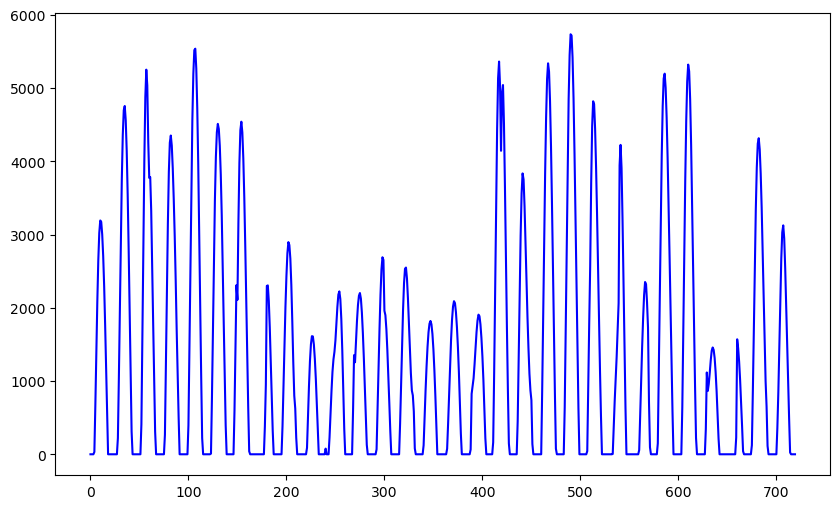

In [262]:
plt.figure(figsize=(10,6))
plt.plot(pred_a, color="blue")
plt.plot(pred_b, color="red")
plt.plot(pred_c, color="green")

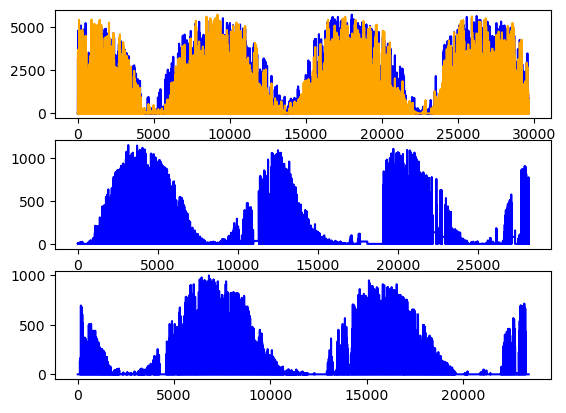

In [263]:

fig, axs = plt.subplots(3)

axs[0].plot(train_a_y.flatten() * a_max, color="blue")
axs[0].plot(pred_a_train, color="orange")

axs[1].plot(train_b_y.flatten() * b_max, color="blue")
axs[1].plot(pred_b_train, color="orange")

axs[2].plot(train_c_y.flatten() * c_max, color="blue")
axs[2].plot(pred_c_train, color="orange")

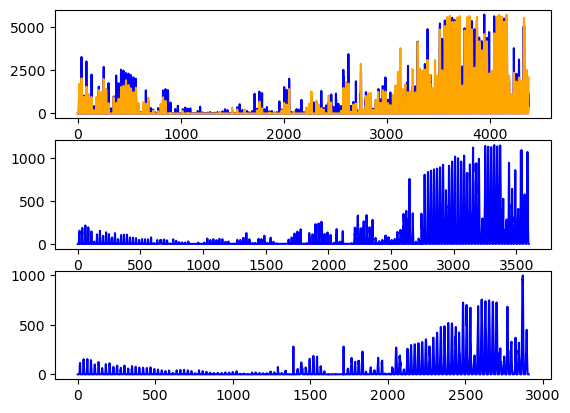

In [264]:
fig, axs = plt.subplots(3)

axs[0].plot(val_a_y.flatten() * a_max, color="blue")
axs[0].plot(pred_a_val, color="orange")

axs[1].plot(val_b_y.flatten() * b_max, color="blue")
axs[1].plot(pred_b_val, color="orange")

axs[2].plot(val_c_y.flatten() * c_max, color="blue")
axs[2].plot(pred_c_val, color="orange")

In [59]:
test = pd.read_csv('test.csv')

test

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0,A
1,1,2023-05-01 01:00:00,0,A
2,2,2023-05-01 02:00:00,0,A
3,3,2023-05-01 03:00:00,0,A
4,4,2023-05-01 04:00:00,0,A
...,...,...,...,...
2155,2155,2023-07-03 19:00:00,0,C
2156,2156,2023-07-03 20:00:00,0,C
2157,2157,2023-07-03 21:00:00,0,C
2158,2158,2023-07-03 22:00:00,0,C


In [60]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,id,prediction
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2155,2155,0
2156,2156,0
2157,2157,0
2158,2158,0


In [61]:
submit = np.concatenate((np.concatenate((preds_a_test, preds_b_test)),preds_c_test))

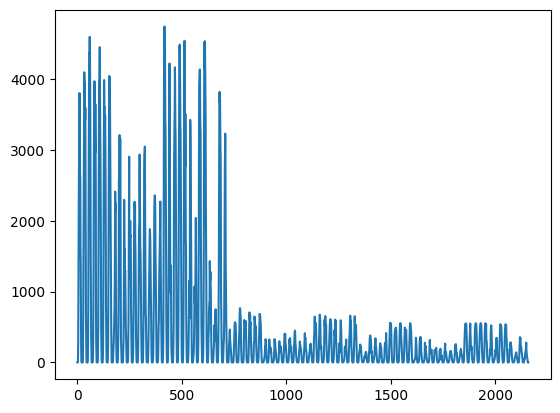

In [62]:
plt.plot(submit)

In [63]:
from datetime import datetime

now = datetime.now() # current date and time

# Example, let the predictions be random values
test['prediction'] = submit
sample_submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv("xgboost_4.csv", index=False)